In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd


In [2]:
#Load, filter and concatenate individual variant libraries

variant_library_df = pd.read_csv("apa_100_variants_rev2_20220621_pred.csv", sep='\t')


In [3]:

variant_library_df


,gene,gene_id,chrom,strand,snp_id,data_source,experiment,pas_pos,pas_pos_hg38,var_position,...,delta_logodds_0_205,ref_barcode,var_barcode,ref_var_hamming_dist,ref_var_hamming_dist_w_homology,ref_logit_corrected_77_127,var_logit_corrected_77_127,ref_iso_corrected_77_127,var_iso_corrected_77_127,delta_iso_corrected_77_127
0,CYP4F22,CYP4F22.1,Missing,Missing,Missing,Array_2019,control_CYP4F22.1,-1,-1,-1,...,0.0000,GATGCAGCTGGCTATCATGA,GATGCAGCTGGCTATCATGA,0,0,-3.845289,-3.845289,0.020933,0.020933,0.000000
1,BBS2,BBS2.3,Missing,Missing,Missing,Array_2019,control_BBS2.3,-1,-1,-1,...,0.0000,AAGGCATCAGTAATATGGCT,AAGGCATCAGTAATATGGCT,0,0,-2.412180,-2.412180,0.082249,0.082249,0.000000
2,CANT1,CANT1.3,Missing,Missing,Missing,Array_2019,control_CANT1.3,-1,-1,-1,...,0.0000,TCTAGCCGCTGTTTATTCCT,TCTAGCCGCTGTTTATTCCT,0,0,-1.258612,-1.258612,0.221213,0.221213,0.000000
3,COL4A4,COL4A4.1,Missing,Missing,Missing,Array_2019,control_COL4A4.1,-1,-1,-1,...,0.0000,ACGTGGCCCAGTCGGCGCCA,ACGTGGCCCAGTCGGCGCCA,0,0,-0.352120,-0.352120,0.412868,0.412868,0.000000
4,RYR2,RYR2.1,Missing,Missing,Missing,Array_2019,control_RYR2.1,-1,-1,-1,...,0.0000,ATTAAGTTCTTCGCGCTACC,ATTAAGTTCTTCGCGCTACC,0,0,0.175781,0.175781,0.543832,0.543832,0.000000
5,RB1,RB1.11,Missing,Missing,Missing,Array_2019,control_RB1.11,-1,-1,-1,...,0.0000,CCTAAGTGGGACATCCCCCA,CCTAAGTGGGACATCCCCCA,0,0,1.479299,1.479299,0.814467,0.814467,0.000000
6,CRLS1,CRLS1.9,chr20,+,rs2235816,aQTL,brain_specific_variant,6018668,-1,6018711,...,0.6058,TATCAAGCTGTATATTTTTC,TATCAAGCTGTATATTTTTC,1,1,-1.349316,-0.760793,0.205982,0.318474,0.112492
7,ALDH7A1,ALDH7A1.17,chr5,-,rs744722,aQTL,brain_specific_variant,125878941,-1,125878908,...,-0.4368,AAACAAATTTATAATTTTTC,AAACAAATTTATAATTTTTC,1,1,-0.113299,-0.528667,0.471706,0.370828,-0.100878
8,ALDH7A1,ALDH7A1.17,chr5,-,rs744722_control,aQTL,brain_specific_variant,125878941,-1,125878908,...,0.0254,CATCTACTTACCAGTTCCTG,CATCTACTTACCAGTTCCTG,1,1,-0.063590,-0.039928,0.484108,0.490019,0.005911
9,F2,F2.1,chr11,+,rs1799963,gnomAD_F2,variant,46761035,46739485,46761055,...,0.3227,CTCATATTCTGGGCTCCTGG,CTCATATTCTGGGCTCCTGG,1,1,-1.379949,-1.064731,0.201017,0.256406,0.055389


In [4]:
#Load oligo array from 2019

import isolearn.io as isoio

isoform_pseudo_count = 1.
proximal_start = 0
proximal_end = 205

file_prefix = str(proximal_start) + "_" + str(proximal_end)

seq_dict = isoio.load('../../../../aparent/data/prepared_data/apa_array_data/apa_array_data_seq')

#Load predictions (Resnet)
model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'
pred_dict = isoio.load('../../../analysis/predictions/apa_array_data_legacy/' + model_name + '_predictions_seq')


In [5]:

print("n (sequences) = " + str(len(seq_dict['array_df'])))


n (sequences) = 186066


In [6]:

seq_df = seq_dict['array_df']
seq_cuts = seq_dict['pooled_cuts']

pred_df = pred_dict['array_df']
cuts_pred = pred_dict['cut_prob']

seq_df['row_index_true'] = np.arange(len(seq_df), dtype=np.int)
pred_df['row_index_pred'] = np.arange(len(pred_df), dtype=np.int)

seq_df = seq_df.join(pred_df[['seq', 'row_index_pred']].set_index('seq'), on='seq', how='inner').copy().reset_index(drop=True)

seq_cuts = seq_cuts[np.ravel(seq_df['row_index_true'].values), :]
cut_true = np.concatenate([np.array(seq_cuts[:, 180: 180 + 205].todense()), np.array(seq_cuts[:, -1].todense()).reshape(-1, 1)], axis=-1)# - 1

seq_df['proximal_count'] = [np.sum(cut_true[i, proximal_start:proximal_end]) for i in range(len(seq_df))]
seq_df['total_count'] = [np.sum(cut_true[i, :]) for i in range(len(seq_df))]

seq_df['iso_true'] = (seq_df['proximal_count'] + isoform_pseudo_count) / (seq_df['total_count'] + 2. * isoform_pseudo_count)
seq_df['logodds_true'] = np.log(seq_df['iso_true'] / (1.0 - seq_df['iso_true']))

cut_pred = np.array(cuts_pred[np.ravel(seq_df['row_index_pred'].values), :].todense())

seq_df['iso_pred'] = [np.clip(np.sum(cut_pred[i, proximal_start:proximal_end]), 1e-6, 1. - 1e-6) for i in range(len(seq_df))]
seq_df['logodds_pred'] = np.log(seq_df['iso_pred'] / (1.0 - seq_df['iso_pred']))


In [7]:
#Filter on high quality

print("n (pre-filtering) = " + str(len(seq_df)))

seq_df = seq_df.query("n_barcodes >= 2 and mean_total_count >= 200 and variant == 'wt'").copy().reset_index(drop=True)
seq_df = seq_df.loc[seq_df['experiment'].isin([
    'sensitive_genes',
    #'tgta',
    'acmg_apadb',
    'human variant',
    #'intronic_pas',
    #'max_cut',
    #'max_iso',
    #'clinvar_mut',
    'acmg_polyadb',
    'clinvar_wt'
])].copy().reset_index(drop=True)

seq_df = seq_df.loc[~seq_df['seq'].str.contains("AAAAAAAAA|AAAAGAAAA|AAAACAAAA|AAAATAAAA")].copy().reset_index(drop=True)

print("n (post-filtering) = " + str(len(seq_df)))


n (pre-filtering) = 186066
n (post-filtering) = 4938


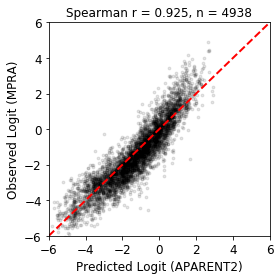

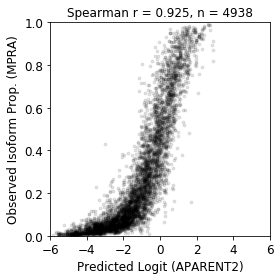

In [8]:
from scipy.stats import spearmanr, pearsonr

r_val = spearmanr(seq_df['logodds_pred'], seq_df['logodds_true'])[0]

f = plt.figure(figsize=(4, 4))

plt.scatter(seq_df['logodds_pred'], seq_df['logodds_true'], color='black', s=8, alpha=0.1)

plt.plot([-6., 6.], [-6. ,6.], linewidth=2, linestyle='--', color='red')

plt.xlim(-6., 6.)
plt.ylim(-6., 6.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Logit (APARENT2)", fontsize=12)
plt.ylabel("Observed Logit (MPRA)", fontsize=12)

plt.title("Spearman r = " + str(round(r_val, 3)) + ", n = " + str(len(seq_df)))

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(4, 4))

plt.scatter(seq_df['logodds_pred'], seq_df['iso_true'], color='black', s=8, alpha=0.1)

plt.xlim(-6., 6.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Logit (APARENT2)", fontsize=12)
plt.ylabel("Observed Isoform Prop. (MPRA)", fontsize=12)

plt.title("Spearman r = " + str(round(r_val, 3)) + ", n = " + str(len(seq_df)))

plt.tight_layout()

plt.show()


lr.coef_ = [1.02066055]
lr.intercept_ = -0.08618932535858814
R^2 = 0.832


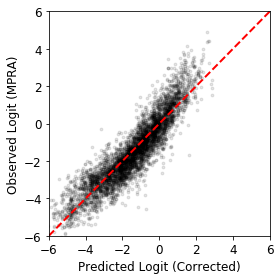

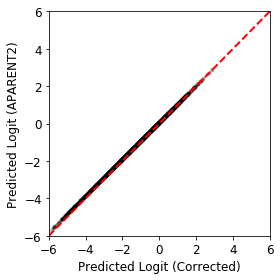

In [9]:
#Perform logit regression

from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(
    np.array(seq_df['logodds_pred'].values)[:, None],
    np.array(seq_df['logodds_true'].values)
)

print("lr.coef_ = " + str(lr.coef_))
print("lr.intercept_ = " + str(lr.intercept_))

print("R^2 = " + str(round(lr.score(
    np.array(seq_df['logodds_pred'].values)[:, None],
    np.array(seq_df['logodds_true'].values)
), 3)))

seq_df['logodds_pred_corrected'] = np.ravel(lr.predict(np.array(seq_df['logodds_pred'].values)[:, None]))

f = plt.figure(figsize=(4, 4))

plt.scatter(seq_df['logodds_pred_corrected'], seq_df['logodds_true'], color='black', s=8, alpha=0.1)

plt.plot([-6., 6.], [-6. ,6.], linewidth=2, linestyle='--', color='red')

plt.xlim(-6., 6.)
plt.ylim(-6., 6.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Logit (Corrected)", fontsize=12)
plt.ylabel("Observed Logit (MPRA)", fontsize=12)

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(4, 4))

plt.scatter(seq_df['logodds_pred_corrected'], seq_df['logodds_pred'], color='black', s=8, alpha=0.1)

plt.plot([-6., 6.], [-6. ,6.], linewidth=2, linestyle='--', color='red')

plt.xlim(-6., 6.)
plt.ylim(-6., 6.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Logit (Corrected)", fontsize=12)
plt.ylabel("Predicted Logit (APARENT2)", fontsize=12)

plt.tight_layout()

plt.show()


In [10]:
#Impute reporter-context isoform abundances for new library

variant_library_df['ref_logit_corrected_' + str(proximal_start) + "_" + str(proximal_end)] = np.ravel(lr.predict(np.array(variant_library_df['ref_logit_pred_' + str(proximal_start) + "_" + str(proximal_end)])[:, None]))
variant_library_df['var_logit_corrected_' + str(proximal_start) + "_" + str(proximal_end)] = np.ravel(lr.predict(np.array(variant_library_df['var_logit_pred_' + str(proximal_start) + "_" + str(proximal_end)])[:, None]))

variant_library_df['ref_iso_corrected_' + str(proximal_start) + "_" + str(proximal_end)] = 1. / (1. + np.exp(-variant_library_df['ref_logit_corrected_' + str(proximal_start) + "_" + str(proximal_end)]))
variant_library_df['var_iso_corrected_' + str(proximal_start) + "_" + str(proximal_end)] = 1. / (1. + np.exp(-variant_library_df['var_logit_corrected_' + str(proximal_start) + "_" + str(proximal_end)]))

variant_library_df['delta_iso_corrected_' + str(proximal_start) + "_" + str(proximal_end)] = variant_library_df['var_iso_corrected_' + str(proximal_start) + "_" + str(proximal_end)] - variant_library_df['ref_iso_corrected_' + str(proximal_start) + "_" + str(proximal_end)]


In [11]:

variant_library_df


,gene,gene_id,chrom,strand,snp_id,data_source,experiment,pas_pos,pas_pos_hg38,var_position,...,ref_logit_corrected_77_127,var_logit_corrected_77_127,ref_iso_corrected_77_127,var_iso_corrected_77_127,delta_iso_corrected_77_127,ref_logit_corrected_0_205,var_logit_corrected_0_205,ref_iso_corrected_0_205,var_iso_corrected_0_205,delta_iso_corrected_0_205
0,CYP4F22,CYP4F22.1,Missing,Missing,Missing,Array_2019,control_CYP4F22.1,-1,-1,-1,...,-3.845289,-3.845289,0.020933,0.020933,0.000000,-3.842118,-3.842118,0.020998,0.020998,0.000000
1,BBS2,BBS2.3,Missing,Missing,Missing,Array_2019,control_BBS2.3,-1,-1,-1,...,-2.412180,-2.412180,0.082249,0.082249,0.000000,-0.275216,-0.275216,0.431627,0.431627,0.000000
2,CANT1,CANT1.3,Missing,Missing,Missing,Array_2019,control_CANT1.3,-1,-1,-1,...,-1.258612,-1.258612,0.221213,0.221213,0.000000,-1.131754,-1.131754,0.243838,0.243838,0.000000
3,COL4A4,COL4A4.1,Missing,Missing,Missing,Array_2019,control_COL4A4.1,-1,-1,-1,...,-0.352120,-0.352120,0.412868,0.412868,0.000000,-0.163351,-0.163351,0.459253,0.459253,0.000000
4,RYR2,RYR2.1,Missing,Missing,Missing,Array_2019,control_RYR2.1,-1,-1,-1,...,0.175781,0.175781,0.543832,0.543832,0.000000,0.477521,0.477521,0.617162,0.617162,0.000000
5,RB1,RB1.11,Missing,Missing,Missing,Array_2019,control_RB1.11,-1,-1,-1,...,1.479299,1.479299,0.814467,0.814467,0.000000,1.884298,1.884298,0.868104,0.868104,0.000000
6,CRLS1,CRLS1.9,chr20,+,rs2235816,aQTL,brain_specific_variant,6018668,-1,6018711,...,-1.349316,-0.760793,0.205982,0.318474,0.112492,-1.179113,-0.560694,0.235212,0.363387,0.128175
7,ALDH7A1,ALDH7A1.17,chr5,-,rs744722,aQTL,brain_specific_variant,125878941,-1,125878908,...,-0.113299,-0.528667,0.471706,0.370828,-0.100878,0.133151,-0.312776,0.533239,0.422437,-0.110801
8,ALDH7A1,ALDH7A1.17,chr5,-,rs744722_control,aQTL,brain_specific_variant,125878941,-1,125878908,...,-0.063590,-0.039928,0.484108,0.490019,0.005911,0.131926,0.157851,0.532934,0.539381,0.006447
9,F2,F2.1,chr11,+,rs1799963,gnomAD_F2,variant,46761035,46739485,46761055,...,-1.379949,-1.064731,0.201017,0.256406,0.055389,-1.253825,-0.924560,0.222039,0.284030,0.061991


In [12]:

variant_library_df.to_csv("apa_100_variants_rev2_20220621_pred.csv", index=False, sep='\t')
